In [1]:
import sys
sys.path.append("../../../NvTK/")
print(sys.path)

['/media/ggj/Files/mount/NvTK/Tutorials/2_NvTK_reproduce_published_models', '/media/ggj/Files/mount/NvTK/Tutorials/2_NvTK_reproduce_published_models', '/media/ggj/878c2958-f806-4cd3-9b9f-ad94b4b696d9/ggj/jiaqiLi/MachineLearning/PE/WindLinuxAPIForX86', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python37.zip', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/lib-dynload', '', '/home/ggj/.local/lib/python3.7/site-packages', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/pycocotools-2.0-py3.7-linux-x86_64.egg', '/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/IPython/extensions', '/home/ggj/.ipython', '../../../NvTK/']


In [2]:
import h5py, os, argparse, logging, time

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from NvTK import Trainer
from NvTK.Model.Publications import DeepSEA

from NvTK.Evaluator import calculate_roc, calculate_pr
from NvTK.Evaluator import show_auc_curve, show_pr_curve

from NvTK.Explainer import get_activate_W, meme_generate, save_activate_seqlets
from NvTK.Explainer import seq_logo, plot_seq_logo

In [3]:
os.makedirs("./Log", exist_ok=True)
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                    datefmt='%a, %d %b %Y %H:%M:%S',
                    filename=time.strftime('./Log/log_nvtk_minimal.%m%d.%H:%M:%S.txt'),
                    filemode='w')

# args
parser = argparse.ArgumentParser()
parser.add_argument("data")
parser.add_argument("--gpu-device", dest="device_id", default="0")
args = parser.parse_args(['./Dataset.sciATAC1_train_test.h5', 
                          '--gpu-device', '0'])
logging.info(args)


In [4]:
## change device
os.environ["CUDA_VISIBLE_DEVICES"] = args.device_id
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Prepare dataset

1. unpack the h5file datasets
2. generate the DataLoader

In [6]:
# unpack datasets
h5file = h5py.File(args.data, 'r')
anno = h5file["annotation"][:]
x_train = h5file["train_data"][:].astype(np.float32)
y_train = h5file["train_label"][:].astype(np.float32)
x_val = h5file["val_data"][:].astype(np.float32)
y_val = h5file["val_label"][:].astype(np.float32)
x_test = h5file["test_data"][:].astype(np.float32)
y_test = h5file["test_label"][:].astype(np.float32)
h5file.close()

# unpack anno
n_tasks = anno.shape[0]
task_name = anno[:,0]

# define data loader
batch_size = 32
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,
                            shuffle=True, num_workers=2, drop_last=False, pin_memory=True)
validate_loader = DataLoader(list(zip(x_val, y_val)), batch_size=batch_size, 
                            shuffle=False, num_workers=2, drop_last=False, pin_memory=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size, 
                            shuffle=False, num_workers=2, drop_last=False, pin_memory=True)


## Define DeepSEA model
Initialized DeepSEA architectures in NvTK

In [8]:
# define model
model = DeepSEA(sequence_length=600, n_genomic_features=85)
model

DeepSEA(
  (conv_net): Sequential(
    (0): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
    (1): ReLU(inplace)
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2)
    (4): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
    (5): ReLU(inplace)
    (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2)
    (8): Conv1d(480, 960, kernel_size=(8,), stride=(1,))
    (9): ReLU(inplace)
    (10): Dropout(p=0.5)
  )
  (classifier): Sequential(
    (0): Linear(in_features=26880, out_features=85, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=85, out_features=85, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss().to(device)

trainer = Trainer(model, criterion, optimizer, device, 
                  tasktype='binary_classification', 
                  use_tensorbord=False, tensorbord_args={})

## Trained the model 

as an example, we only train the DeepSEA model architectures on sciATAC1 dataset for 2 EPOCHs.

In [10]:
# train
trainer.train_until_converge(train_loader, validate_loader, test_loader, EPOCH=2)

In [ ]:
# if you have enabled tensorboard
!tensorboard --logdir=runs --bind_all

## Evaluated the model

In [11]:
model = trainer.load_best_model()

In [12]:
# predict test-set
_, _, test_predictions, test_targets = trainer.predict(test_loader)

# metric test-set
fpr, tpr, roc_auc = calculate_roc(test_targets, test_predictions)
auroc = [roc_auc[k] for k in roc_auc.keys() if k not in ["macro", "micro"]] # dict keys ordered by default in py3.7+

p, r, average_precision = calculate_pr(test_targets, test_predictions)
aupr = [average_precision[k] for k in average_precision.keys() if k not in ["macro", "micro"]] # dict keys ordered by default in py3.7+

pd.DataFrame({"auroc":auroc, "aupr":aupr}, index=anno[:,0]).to_csv("Metric.DeepSEA_sciATAC1.csv")

<Figure size 432x288 with 0 Axes>

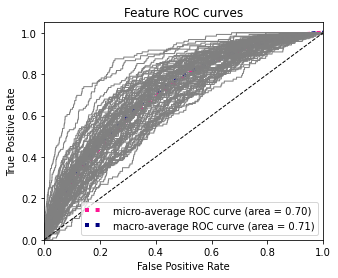

In [13]:
show_auc_curve(fpr=fpr, tpr=tpr, roc_auc=roc_auc, save=False, fig_size=(5, 4))

## Model Interpretation
The sequence pattern deep learning represented internally for its accurate prediction.

Note: DeepSEA architecture have NO `model.Embedding.conv layer`, which is different to the NvTK predifined models.
We calculated the first-layer convolutional layer `model.conv_net[0]` as `hook_module` instead.
And the `motif_width` could be the filter_size of DeepSEA `model.conv_net[0]`.

In [14]:
# explain
W = get_activate_W(model, model.conv_net[0], test_loader, threshold=0.999, motif_width=8)
meme_generate(W, output_file='meme-simple.txt', prefix='Filter_')

/home/ggj/anaconda3/envs/pytorch-cuda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 5.08 s, sys: 17.4 s, total: 22.5 s
Wall time: 53 s


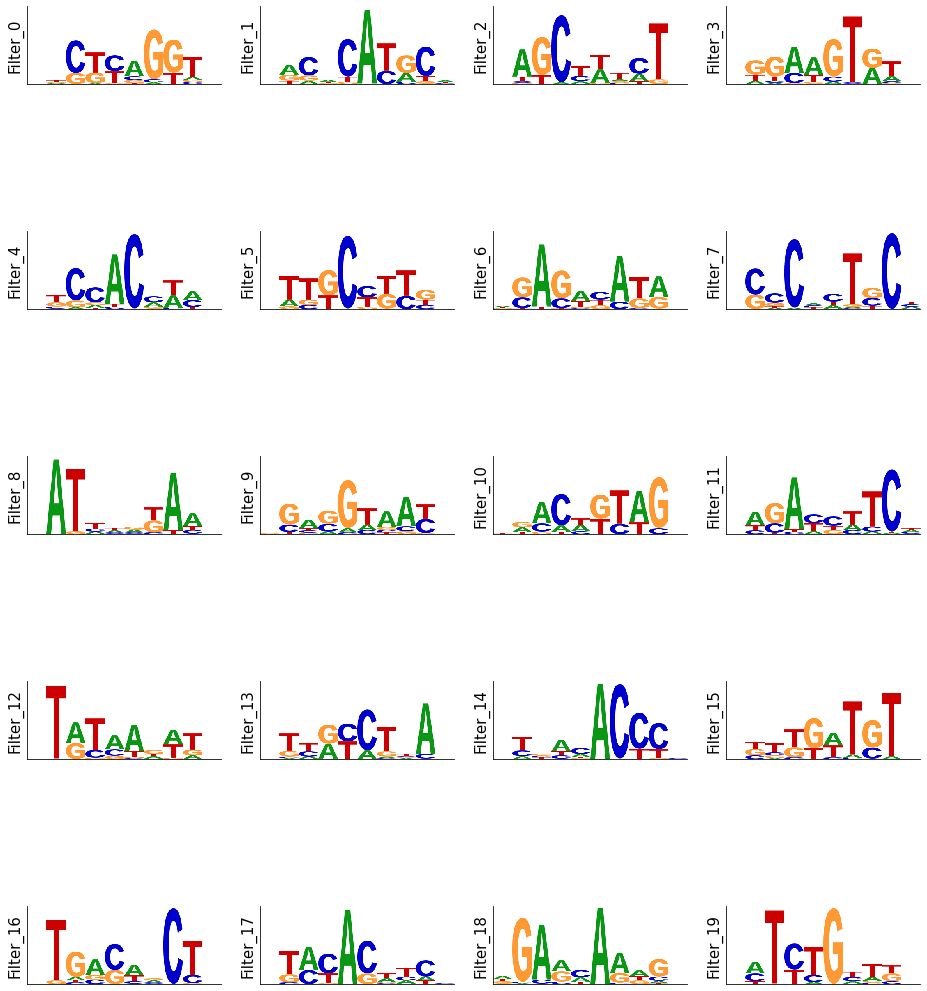

In [17]:
%%time

import matplotlib.pyplot as plt
from NvTK.Explainer import normalize_pwm

save_path = "./Motifs"

fig = plt.figure(figsize = (16, 20))
for j in range(len(W[:20])):  
    
    plt.subplot(5, 4, j+1)
    logo = seq_logo(W[j], height=100, nt_width=50, norm=0, alphabet='dna')
    plot_seq_logo(logo, nt_width=20, step_multiple=4)    
    plt.xticks([])
    plt.yticks([])
    plt.ylabel("Filter_"+str(j), fontsize=15)

fig.savefig("Filters.DeepSEA_sciATAC1.pdf", format='pdf', dpi=300, bbox_inches='tight')
fig.show()
